<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/03_advanced/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

tf.enable_eager_execution()
L = tf.keras.layers
metrics = tf.keras.metrics

In [0]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 100

In [3]:
train_data, test_data = tf.keras.datasets.mnist.load_data()

N = train_data[0].shape[0]
N

11493376/11490434 [==============================] - 0s 0us/step


60000

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_data[0].reshape(-1, 28, 28, 1).astype(np.float32) / 255, 
    train_data[1].astype(np.int32)
)).batch(batch_size).shuffle(10000)

train_dataset

<ShuffleDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>

In [47]:
D = tf.keras.Sequential([
    L.InputLayer([28, 28, 1]),
    L.Flatten(),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(1, activation=tf.nn.sigmoid),
])

D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
_________________________________________________________________


In [48]:
G = tf.keras.Sequential([
    L.InputLayer([latent_size]),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(784, activation=tf.nn.tanh),
    L.Reshape([28, 28, 1])
])

G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
_________________________________________________________________


In [0]:
def loss_fn(y, y_pre):
    return tf.reduce_sum(metrics.binary_crossentropy(y, y_pre))

optimizer = tf.train.AdamOptimizer(learning_rate=2e-4)

def denorm(x):
    out = (x + 1) / 2
    return tf.clip_by_value(x, 0, 1)

In [0]:
@tf.contrib.eager.defun
def D_train(images):
    real_labels = tf.ones([batch_size, 1])
    fake_labels = tf.zeros([batch_size, 1])    

    # Compute BCE_Loss using real images where BCE_Loss(x, y): 
    #         - y * log(D(x)) - (1-y) * log(1 - D(x))
    # Second term of the loss is always zero since real_labels == 1
    
    with tf.GradientTape() as g:
        g.watch(D.variables)
        outputs = D(images)
        d_loss_real = loss_fn(real_labels, outputs)
    
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = tf.random_normal([batch_size, latent_size])
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = loss_fn(fake_labels, outputs)
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
    
    grads = g.gradient(d_loss, D.variables)
    optimizer.apply_gradients(zip(grads, D.variables))
    
    return d_loss

In [0]:
@tf.contrib.eager.defun
def G_train():
    real_labels = tf.ones([batch_size, 1])
    # Compute loss with fake images
    z = tf.random_normal([batch_size, latent_size])
    
    with tf.GradientTape() as g:
        g.watch(G.variables)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. 
        # https://arxiv.org/pdf/1406.2661.pdf
        g_loss = loss_fn(real_labels, outputs)

    # Backprop and optimize
    grads = g.gradient(g_loss, G.variables)
    optimizer.apply_gradients(zip(grads, G.variables))    

    return g_loss

In [52]:
# Start training
total_step = N // batch_size
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dataset):

        with tf.device("/gpu:0"):

            d_loss = D_train(images)

            g_loss = G_train()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, 
                          d_loss.numpy(), g_loss.numpy()))

Epoch [0/50], Step [200/600], d_loss: 9.2554, g_loss: 740.2656
Epoch [0/50], Step [400/600], d_loss: 8.2782, g_loss: 1104.1801
Epoch [0/50], Step [600/600], d_loss: 13.6297, g_loss: 1083.5762
Epoch [1/50], Step [200/600], d_loss: 21.3965, g_loss: 523.4420
Epoch [1/50], Step [400/600], d_loss: 119.9023, g_loss: 209.6857
Epoch [1/50], Step [600/600], d_loss: 23.2452, g_loss: 398.6872
Epoch [2/50], Step [200/600], d_loss: 21.8162, g_loss: 295.7632
Epoch [2/50], Step [400/600], d_loss: 22.6837, g_loss: 323.8384
Epoch [2/50], Step [600/600], d_loss: 3.2099, g_loss: 591.1722
Epoch [3/50], Step [200/600], d_loss: 5.1135, g_loss: 461.4583
Epoch [3/50], Step [400/600], d_loss: 18.2868, g_loss: 540.5867
Epoch [3/50], Step [600/600], d_loss: 8.8716, g_loss: 653.5228
Epoch [4/50], Step [200/600], d_loss: 12.1622, g_loss: 470.1958
Epoch [4/50], Step [400/600], d_loss: 7.6254, g_loss: 552.0044
Epoch [4/50], Step [600/600], d_loss: 8.3175, g_loss: 497.2496
Epoch [5/50], Step [200/600], d_loss: 10.723

In [0]:
image_generated = G(tf.random_normal([10, latent_size]))

In [0]:
image_generated_numpy = image_generated.numpy().reshape(-1, 28, 28)

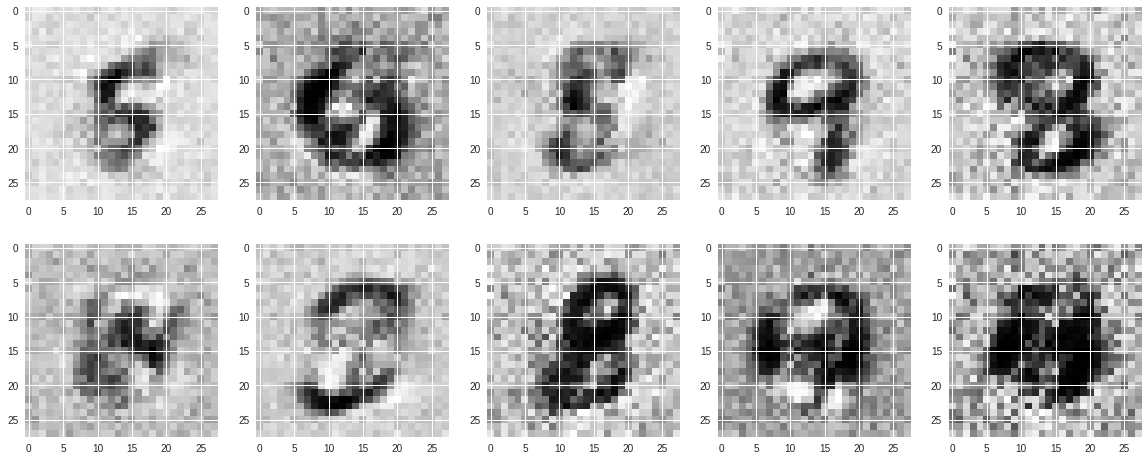

In [55]:
plt.figure(figsize=(20, 8))
for i, img_show in enumerate(image_generated_numpy):
    plt.subplot(2, 5, i+1)
    plt.imshow(img_show)